In [1]:
dir = '../input/cassava-leaf-disease-classification/'

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.cm as cm
from tensorflow import keras
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

# Importing data

In [3]:
df = pd.read_csv(dir + 'train.csv')
df.head()

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


In [4]:
data = list()
label = list()
img_size = 32

for i in df.image_id[:15000]:
    img = cv2.imread(dir +'train_images/'+ i)
    img = cv2.resize(img, (img_size, img_size))
    img = img.astype('float32')
    data.append(img)
    
label = df.label.tolist()
label = label[:15000]
data = np.array(data)

# Preprocessing

In [5]:
data_label = np.array(label)

In [6]:
data = data / 255.0
reshaped_data = data.reshape(len(data), -1)

reshaped_data.shape

(15000, 3072)

# Standard KMeans

In [7]:
kmeans = KMeans(n_clusters = 5, random_state = 0)

clusters = kmeans.fit_predict(reshaped_data)
kmeans.cluster_centers_.shape

(5, 3072)

# Scatter Plot of Centroids

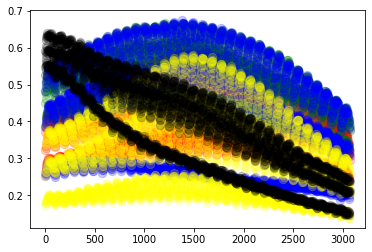

In [8]:
x_data = [i for i in range(3072)]
plt.scatter(x_data, kmeans.cluster_centers_[0], color = 'red', alpha = 0.2, s = 70)
plt.scatter(x_data, kmeans.cluster_centers_[1], color = 'green', alpha = 0.2, s = 70)
plt.scatter(x_data, kmeans.cluster_centers_[2], color = 'blue', alpha = 0.2, s = 70)
plt.scatter(x_data, kmeans.cluster_centers_[3], color = 'yellow', alpha = 0.2, s = 70)
plt.scatter(x_data, kmeans.cluster_centers_[4], color = 'black', alpha = 0.2, s = 70)

# Mapping the labels

In [9]:
# mapping labels from cluster to original labels
def get_reference_dict(clusters, data_label):
    reference_label = dict()
    
    for i in range(len(np.unique(clusters))):
        index = np.where(clusters == i, 1, 0)
        num = np.bincount(data_label[index == 1]).argmax()
        reference_label[i] = num
    
    return reference_label

# Mapping predictions to original labels
def get_labels(clusters, references_labels):
    temp_labels = np.random.rand(len(clusters))
    
    for i in range(len(clusters)):
        temp_labels[i] = reference_labels[clusters[i]]
        
    return temp_labels

In [10]:
reference_labels = get_reference_dict(clusters, data_label)
predicted_labels = get_labels(clusters, reference_labels)

print('Accuracy Score:', accuracy_score(predicted_labels, data_label))

Accuracy Score: 0.6137333333333334


Text(0.5, 15.0, 'predicted label')

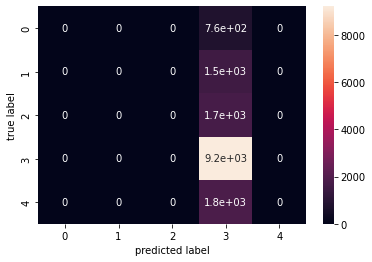

In [11]:
mat = confusion_matrix(data_label,predicted_labels)
sns.heatmap(mat, annot=True)
plt.ylabel('true label')
plt.xlabel('predicted label')

# Elbow Method

Accuracy for k = 5 0.6137333333333334
Accuracy for k = 25 0.6137333333333334
Accuracy for k = 125 0.6158
Accuracy for k = 625 0.6292


Text(0, 0.5, 'Sum of squared distance')

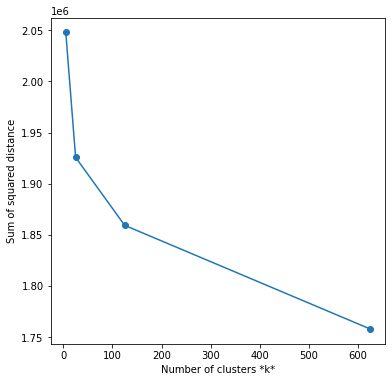

In [12]:
sse = list()
list_k = [5, 25, 125, 625]

for k in list_k:
    km = KMeans(n_clusters = k)
    clusters = km.fit_predict(reshaped_data)
    sse.append(km.inertia_)
    reference_labels = get_reference_dict(clusters, data_label)
    predicted_labels = get_labels(clusters, reference_labels)
    
    print(f'Accuracy for k = {k}', accuracy_score(predicted_labels, data_label))
    
# Plot sse against k
plt.figure(figsize = (6, 6))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance')

# Transfer Learning

In [13]:
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.preprocessing import image

In [14]:
# Extracting features
def extract_vector(data_holder):
    resnet_feature_list = []
    
    for im in data_holder:
        im = image.img_to_array(im)
        img = preprocess_input(np.expand_dims(im.copy(), axis = 0))
        resnet_feature = model.predict(img)
        resnet_feature_np = np.array(resnet_feature)
        resnet_feature_list.append(resnet_feature_np.flatten())
        
    return np.array(resnet_feature_list)

In [15]:
model = ResNet50(weights = 'imagenet', include_top = False)

2022-05-02 15:19:34.666785: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 15:19:34.781673: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 15:19:34.782454: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-05-02 15:19:34.783526: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

94781440/94765736 [==============================] - 1s 0us/step


In [21]:
array = extract_vector(data)
kmeans = KMeans(n_clusters = 625, random_state = 0)
a = kmeans.fit(array)
clusters = kmeans.fit_predict(array)

In [17]:
reference_labels = get_reference_dict(clusters, data_label)
predicted_labels = get_labels(clusters, reference_labels)

Text(0.5, 15.0, 'Predicted Label')

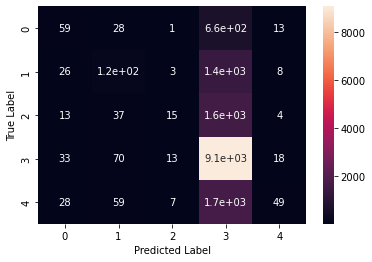

In [18]:
mat = confusion_matrix(data_label, predicted_labels)
sns.heatmap(mat, annot = True)
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

In [19]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

print('Accuracy Score:', accuracy_score(predicted_labels, data_label))
print('Precision:', precision_score(predicted_labels, data_label, average = 'micro'))
print('Recall:', recall_score(predicted_labels, data_label, average = 'micro'))
print('F1 Score:', f1_score(predicted_labels, data_label, average = 'micro'))

Accuracy Score: 0.6209333333333333
Precision: 0.6209333333333333
Recall: 0.6209333333333333
F1 Score: 0.6209333333333333
